# Лабораторна робота №4: Нейронні мережі

## Мета роботи
Удосконалити інтелектуального агента-автомобіля з попередньої лабораторної роботи – додати йому систему контролю швидкості на основі згорткової нейронної мережі.

## Завдання
- Отримати базові навички роботи з нейронними мережами
- Отримати досвід вирішення проблеми класифікації зображень
- Удосконалити агента-автомобіля з попередньої лабораторної роботи

In [1]:
!pip3 install tensorflow matplotlib networkx numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from typing import List, Tuple, Set, Dict, Any
from collections import deque, defaultdict
import time
import json
import os

/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Згорткова нейронна мережа для розпізнавання знаків швидкості

In [3]:
class SpeedSignCNN:
    def __init__(self):
        self.model = None
        self.trained = False
        
    def build_model(self):
        self.model = models.Sequential([
            layers.Reshape((28, 28, 1), input_shape=(28, 28)),
            
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(8, activation='softmax')
        ])
        
        self.model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
        
        print("CNN model built")
        
    def prepare_mnist_data(self):
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        
        train_mask = (y_train >= 2) & (y_train <= 9)
        test_mask = (y_test >= 2) & (y_test <= 9)
        
        x_train_filtered = x_train[train_mask]
        y_train_filtered = y_train[train_mask] - 2
        
        x_test_filtered = x_test[test_mask]
        y_test_filtered = y_test[test_mask] - 2
        
        x_train_filtered = x_train_filtered.astype('float32') / 255.0
        x_test_filtered = x_test_filtered.astype('float32') / 255.0
        
        print(f"Training data: {x_train_filtered.shape}, labels: {np.unique(y_train_filtered)}")
        print(f"Test data: {x_test_filtered.shape}, labels: {np.unique(y_test_filtered)}")
        
        return (x_train_filtered, y_train_filtered), (x_test_filtered, y_test_filtered)
        
    def train_model(self, epochs=5):
        if self.model is None:
            self.build_model()
            
        (x_train, y_train), (x_test, y_test) = self.prepare_mnist_data()
        
        print("training CNN...")
        history = self.model.fit(x_train, y_train,
                                epochs=epochs,
                                batch_size=128,
                                validation_data=(x_test, y_test),
                                verbose=1)
        
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        print(f"test accuracy: {test_acc:.4f}")
        
        self.trained = True
        return history
        
    def predict_speed_limit(self, image):
        if not self.trained:
            print("model not trained")
            return None
            
        if image.shape != (28, 28):
            print(f"wrong image shape: {image.shape}")
            return None
            
        image_normalized = image.astype('float32') / 255.0
        image_batch = np.expand_dims(image_normalized, axis=0)
        
        predictions = self.model.predict(image_batch, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        
        actual_digit = predicted_class + 2
        speed_limit = actual_digit * 10
        
        return {
            'digit': actual_digit,
            'speed_limit': speed_limit,
            'confidence': confidence
        }
        
    def save_model(self, path='speed_sign_model.h5'):
        if self.model:
            self.model.save(path)
            print(f"model saved to {path}")
            
    def load_model(self, path='speed_sign_model.h5'):
        if os.path.exists(path):
            self.model = tf.keras.models.load_model(path)
            self.trained = True
            print(f"model loaded from {path}")
        else:
            print(f"model file {path} not found")

In [5]:
speed_cnn = SpeedSignCNN()
training_history = speed_cnn.train_model(epochs=5)

CNN model built
Training data: (47335, 28, 28), labels: [0 1 2 3 4 5 6 7]
Test data: (7885, 28, 28), labels: [0 1 2 3 4 5 6 7]
training CNN...
Epoch 1/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7997 - loss: 0.6123 - val_accuracy: 0.9828 - val_loss: 0.0573
Epoch 2/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9746 - loss: 0.0819 - val_accuracy: 0.9853 - val_loss: 0.0418
Epoch 3/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9842 - loss: 0.0499 - val_accuracy: 0.9901 - val_loss: 0.0293
Epoch 4/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9880 - loss: 0.0381 - val_accuracy: 0.9915 - val_loss: 0.0251
Epoch 5/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9908 - loss: 0.0304 - val_accuracy: 0.9912 - val_loss: 0.0257
test accuracy: 0.9912


## База знань з Лаб3 (копія)

In [6]:
class KnowledgeBase:
    def __init__(self):
        self.facts = set()
        self.graph_connections = defaultdict(set)
        self.road_signs = {}
        self.visited_intersections = set()
        
    def tell(self, fact):
        if isinstance(fact, dict):
            fact_type = fact.get('type')
            if fact_type == 'connection':
                from_node = fact['from']
                to_node = fact['to']
                self.graph_connections[from_node].add(to_node)
                self.facts.add(f"connected({from_node}, {to_node})")
                
            elif fact_type == 'road_sign':
                road = fact['road']
                target_intersection = fact['target']
                available_directions = fact['directions']
                self.road_signs[road] = {
                    'target': target_intersection,
                    'directions': available_directions
                }
                self.facts.add(f"road_sign({road}, {target_intersection}, {available_directions})")
                
            elif fact_type == 'visited':
                intersection = fact['intersection']
                self.visited_intersections.add(intersection)
                self.facts.add(f"visited({intersection})")
        else:
            self.facts.add(str(fact))
            
    def ask(self, query):
        if isinstance(query, dict):
            query_type = query.get('type')
            
            if query_type == 'path_to_target':
                start = query['start']
                target = query['target']
                return self._find_path_with_knowledge(start, target)
                
            elif query_type == 'best_exploration':
                current = query['current']
                return self._suggest_exploration(current)
                
            elif query_type == 'road_sign_info':
                road = query['road']
                return self.road_signs.get(road, None)
                
        return None
        
    def _find_path_with_knowledge(self, start, target):
        if start == target:
            return [start]
            
        queue = deque([(start, [start])])
        visited = {start}
        
        while queue:
            node, path = queue.popleft()
            
            for neighbor in self.graph_connections[node]:
                if neighbor == target:
                    return path + [neighbor]
                    
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))
        
        return None
        
    def _suggest_exploration(self, current):
        available = list(self.graph_connections[current])
        unvisited = [node for node in available if node not in self.visited_intersections]
        
        if unvisited:
            return random.choice(unvisited)
        elif available:
            return random.choice(available)
        return None
        
    def get_known_connections(self, node):
        return list(self.graph_connections[node])
        
    def is_intersection_known(self, node):
        return node in self.visited_intersections

## Розширений граф з знаками швидкості

In [ ]:
class RoadGraphWithSpeedSigns:
    def __init__(self, size: int, edges_to_remove: int = 0):
        self.size = size
        self.edges_to_remove = edges_to_remove
        self.graph = {}
        self.removed_edges = set()
        self.road_signs = {}
        self.speed_signs = {}
        self.speed_sign_images = {}
        self.generate_grid_graph()
        self.generate_road_signs()
        self.generate_speed_signs()
        
    def generate_grid_graph(self):
        for i in range(self.size):
            for j in range(self.size):
                node = (i, j)
                self.graph[node] = []
                
                if j < self.size - 1:
                    neighbor = (i, j + 1)
                    self.graph[node].append(neighbor)
                
                if i < self.size - 1:
                    neighbor = (i + 1, j)
                    self.graph[node].append(neighbor)
                
                if j > 0:
                    neighbor = (i, j - 1)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
                
                if i > 0:
                    neighbor = (i - 1, j)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
        
        if self.edges_to_remove > 0:
            self.remove_random_edges_safely()
    
    def remove_random_edges_safely(self):
        all_edges = self.get_all_edges()
        total_edges = len(all_edges)
        
        print(f"всього ребер: {total_edges}")
        print(f"запитано видалити: {self.edges_to_remove} ребер")
        
        removed_count = 0
        attempts = 0
        max_attempts = self.edges_to_remove * 100  # збільшуємо кількість спроб
        
        while removed_count < self.edges_to_remove and attempts < max_attempts:
            attempts += 1
            
            # вибираємо випадкове ребро з доступних
            available_edges = [edge for edge in all_edges if tuple(sorted([edge[0], edge[1]])) not in self.removed_edges]
            
            if not available_edges:
                print("немає доступних ребер для видалення")
                break
                
            edge = random.choice(available_edges)
            node1, node2 = edge
            
            # тимчасово видаляємо ребро
            if node2 in self.graph[node1]:
                self.graph[node1].remove(node2)
            if node1 in self.graph[node2]:
                self.graph[node2].remove(node1)
                
            # перевіряємо зв'язність
            if self.is_connected():
                # видалення успішне - зберігаємо зміни
                self.removed_edges.add(tuple(sorted([node1, node2])))
                removed_count += 1
            else:
                # видалення порушило зв'язність - відновлюємо ребро
                if node2 not in self.graph[node1]:
                    self.graph[node1].append(node2)
                if node1 not in self.graph[node2]:
                    self.graph[node2].append(node1)
        
        print(f"фактично видалено: {removed_count} ребер із {self.edges_to_remove} запитаних")
        print(f"граф зв'язний: {'ТАК ✓' if self.is_connected() else 'НІ ✗'}")
        
        # статистика про невдалі спроби
        failed_attempts = attempts - removed_count
        if failed_attempts > 0 and removed_count < self.edges_to_remove:
            print(f"невдалих спроб: {failed_attempts}")
            print(f"можливо, досягнуто максимум видалень для збереження зв'язності")
    
    def get_all_edges(self):
        edges = []
        visited = set()
        for node in self.graph:
            for neighbor in self.graph[node]:
                edge = tuple(sorted([node, neighbor]))
                if edge not in visited:
                    edges.append((node, neighbor))
                    visited.add(edge)
        return edges
    
    def is_connected(self) -> bool:
        if not self.graph:
            return True
        
        start_node = list(self.graph.keys())[0]
        visited = set()
        queue = [start_node]
        
        while queue:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                for neighbor in self.graph[node]:
                    if neighbor not in visited:
                        queue.append(neighbor)
        
        return len(visited) == len(self.graph)
    
    def generate_road_signs(self):
        for node in self.graph:
            for neighbor in self.graph[node]:
                road_key = (node, neighbor)
                target_directions = self.get_directions_at_intersection(neighbor)
                self.road_signs[road_key] = {
                    'target_intersection': neighbor,
                    'available_directions': target_directions
                }
                
    def generate_speed_signs(self):
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        
        train_mask = (y_train >= 2) & (y_train <= 9)
        x_filtered = x_train[train_mask]
        y_filtered = y_train[train_mask]
        
        for node in self.graph:
            for neighbor in self.graph[node]:
                road_key = (node, neighbor)
                
                digit = random.randint(2, 9)
                speed_limit = digit * 10
                
                digit_indices = np.where(y_filtered == digit)[0]
                if len(digit_indices) > 0:
                    random_index = random.choice(digit_indices)
                    speed_sign_image = x_filtered[random_index]
                else:
                    speed_sign_image = np.zeros((28, 28), dtype=np.uint8)
                
                self.speed_signs[road_key] = {
                    'digit': digit,
                    'speed_limit': speed_limit
                }
                
                self.speed_sign_images[road_key] = speed_sign_image
                
        print(f"generated {len(self.speed_signs)} speed signs")
                
    def get_directions_at_intersection(self, intersection):
        neighbors = self.graph.get(intersection, [])
        directions = []
        x, y = intersection
        
        for neighbor in neighbors:
            nx, ny = neighbor
            if nx == x and ny > y:
                directions.append('east')
            elif nx == x and ny < y:
                directions.append('west')
            elif nx > x and ny == y:
                directions.append('south')
            elif nx < x and ny == y:
                directions.append('north')
                
        return directions
    
    def get_road_sign(self, from_node, to_node):
        return self.road_signs.get((from_node, to_node), None)
        
    def get_speed_sign(self, from_node, to_node):
        return self.speed_signs.get((from_node, to_node), None)
        
    def get_speed_sign_image(self, from_node, to_node):
        return self.speed_sign_images.get((from_node, to_node), None)

## Агент з нейронною мережею для контролю швидкості

In [8]:
class NeuralNetworkAgent:
    def __init__(self, road_graph: RoadGraphWithSpeedSigns, start: Tuple[int, int], target: Tuple[int, int], speed_cnn: SpeedSignCNN):
        self.road_graph = road_graph
        self.current_position = start
        self.target_position = target
        self.speed_cnn = speed_cnn
        self.knowledge_base = KnowledgeBase()
        self.path_history = [start]
        self.speed_history = []
        self.steps = 0
        self.current_speed = 0
        self.travel_time = 0.0
        print("neural agent init:", start, "->", target)
        
    def perceive_camera_and_environment(self):
        current = self.current_position
        neighbors = self.road_graph.graph.get(current, [])
        
        self.knowledge_base.tell({
            'type': 'visited',
            'intersection': current
        })
        
        for neighbor in neighbors:
            self.knowledge_base.tell({
                'type': 'connection',
                'from': current,
                'to': neighbor
            })
            
            road_sign = self.road_graph.get_road_sign(current, neighbor)
            if road_sign:
                self.knowledge_base.tell({
                    'type': 'road_sign',
                    'road': (current, neighbor),
                    'target': road_sign['target_intersection'],
                    'directions': road_sign['available_directions']
                })
        
        return neighbors
    
    def recognize_speed_sign_with_camera(self, from_node, to_node):
        speed_sign_image = self.road_graph.get_speed_sign_image(from_node, to_node)
        actual_speed_data = self.road_graph.get_speed_sign(from_node, to_node)
        
        if speed_sign_image is None:
            print(f"no speed sign image for {from_node}->{to_node}")
            return None
            
        recognition_result = self.speed_cnn.predict_speed_limit(speed_sign_image)
        
        if recognition_result:
            recognized_speed = recognition_result['speed_limit']
            confidence = recognition_result['confidence']
            actual_speed = actual_speed_data['speed_limit'] if actual_speed_data else "unknown"
            
            print(f"camera: {from_node}->{to_node} recognized={recognized_speed} km/h (conf={confidence:.3f}) actual={actual_speed} km/h")
            
            return {
                'recognized_speed': recognized_speed,
                'actual_speed': actual_speed,
                'confidence': confidence,
                'accurate': recognized_speed == actual_speed
            }
        
        return None
    
    def ask_knowledge_base_for_action(self):
        if self.current_position == self.target_position:
            print("neural: target reached")
            return None
        
        path_query = {
            'type': 'path_to_target',
            'start': self.current_position,
            'target': self.target_position
        }
        
        known_path = self.knowledge_base.ask(path_query)
        
        if known_path and len(known_path) > 1:
            next_move = known_path[1]
            print(f"neural: following known path to {next_move}")
            return next_move
        
        exploration_query = {
            'type': 'best_exploration',
            'current': self.current_position
        }
        
        exploration_move = self.knowledge_base.ask(exploration_query)
        if exploration_move:
            print(f"neural: exploring {exploration_move}")
            return exploration_move
            
        print("neural: no action available")
        return None
    
    def execute_action_with_speed_control(self, action):
        if action is None:
            return False
        
        from_node = self.current_position
        to_node = action
        
        speed_recognition = self.recognize_speed_sign_with_camera(from_node, to_node)
        
        if speed_recognition:
            self.current_speed = speed_recognition['recognized_speed']
            segment_distance = 1.0
            travel_time_for_segment = segment_distance / (self.current_speed / 60.0) if self.current_speed > 0 else 1.0
            self.travel_time += travel_time_for_segment
        else:
            self.current_speed = 50
            self.travel_time += 1.0
        
        self.current_position = action
        self.path_history.append(action)
        self.speed_history.append(self.current_speed)
        
        return True
    
    def is_target_reached(self):
        return self.current_position == self.target_position
    
    def run_neural_agent_algorithm(self, max_steps=100):
        print("starting neural agent at", self.current_position)
        
        while self.steps < max_steps:
            self.steps += 1
            
            self.perceive_camera_and_environment()
            
            action = self.ask_knowledge_base_for_action()
            
            if not self.execute_action_with_speed_control(action):
                print("neural failed")
                break
                
            if self.is_target_reached():
                print(f"neural success in {self.steps} steps, total time: {self.travel_time:.2f} min")
                return True
        
        print(f"neural timeout after {max_steps} steps")
        return False
    
    def get_journey_summary(self):
        return {
            'total_steps': self.steps,
            'total_time': self.travel_time,
            'path': self.path_history,
            'speeds': self.speed_history,
            'avg_speed': np.mean(self.speed_history) if self.speed_history else 0,
            'max_speed': max(self.speed_history) if self.speed_history else 0,
            'min_speed': min(self.speed_history) if self.speed_history else 0
        }

## Візуалізація з швидкостями

In [9]:
def visualize_neural_agent_with_speeds(road_graph: RoadGraphWithSpeedSigns, agent: NeuralNetworkAgent, title="Neural Agent"):
    plt.figure(figsize=(15, 10))
    
    G = nx.Graph()
    for node in road_graph.graph:
        G.add_node(node)
    
    for node in road_graph.graph:
        for neighbor in road_graph.graph[node]:
            G.add_edge(node, neighbor)
    
    pos = {(i, j): (j, road_graph.size - 1 - i) for i in range(road_graph.size) for j in range(road_graph.size)}
    
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if node == agent.current_position:
            node_colors.append('red')
            node_sizes.append(800)
        elif node == agent.target_position:
            node_colors.append('green')
            node_sizes.append(800)
        elif agent.knowledge_base.is_intersection_known(node):
            node_colors.append('orange')
            node_sizes.append(500)
        else:
            node_colors.append('lightblue')
            node_sizes.append(300)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
    
    labels = {}
    for node in G.nodes():
        if node == agent.current_position:
            labels[node] = f'A\n{agent.current_speed}'
        elif node == agent.target_position:
            labels[node] = 'T'
        else:
            labels[node] = f"{node[0]},{node[1]}"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    if len(agent.path_history) > 1:
        path_edges = [(agent.path_history[i], agent.path_history[i+1]) for i in range(len(agent.path_history)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3, alpha=0.7)
    
    for edge in G.edges():
        node1, node2 = edge
        speed_data = road_graph.get_speed_sign(node1, node2)
        if speed_data:
            x1, y1 = pos[node1]
            x2, y2 = pos[node2]
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            plt.text(mid_x, mid_y, str(speed_data['speed_limit']), 
                    fontsize=8, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.title(f"{title} - Step {agent.steps}, Speed: {agent.current_speed} km/h")
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()

def show_speed_sign_samples(road_graph: RoadGraphWithSpeedSigns, num_samples=6):
    edges = list(road_graph.speed_sign_images.keys())[:num_samples]
    
    plt.figure(figsize=(15, 3))
    for i, edge in enumerate(edges):
        image = road_graph.speed_sign_images[edge]
        speed_data = road_graph.speed_signs[edge]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{edge[0]}->{edge[1]}\n{speed_data['digit']} = {speed_data['speed_limit']} km/h")
        plt.axis('off')
    
    plt.suptitle('Sample Speed Signs on Roads')
    plt.tight_layout()
    plt.show()

def plot_journey_analytics(agent: NeuralNetworkAgent):
    summary = agent.get_journey_summary()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    steps = list(range(1, len(summary['speeds']) + 1))
    ax1.plot(steps, summary['speeds'], 'b-', marker='o', markersize=4)
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Speed (km/h)')
    ax1.set_title('Speed Profile During Journey')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=summary['avg_speed'], color='r', linestyle='--', label=f'Avg: {summary["avg_speed"]:.1f}')
    ax1.legend()
    
    speed_counts = {}
    for speed in summary['speeds']:
        speed_counts[speed] = speed_counts.get(speed, 0) + 1
    
    speeds = list(speed_counts.keys())
    counts = list(speed_counts.values())
    ax2.bar(speeds, counts, alpha=0.7)
    ax2.set_xlabel('Speed Limit (km/h)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Speed Limit Distribution')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Journey Summary:")
    print(f"Total steps: {summary['total_steps']}")
    print(f"Total time: {summary['total_time']:.2f} minutes")
    print(f"Average speed: {summary['avg_speed']:.1f} km/h")
    print(f"Speed range: {summary['min_speed']}-{summary['max_speed']} km/h")

## Тестування агента з нейронною мережею

generated 72 speed signs
Road graph with speed signs created: 5 x 5
Removed edges: 4
Total road signs: 72
Total speed signs: 72


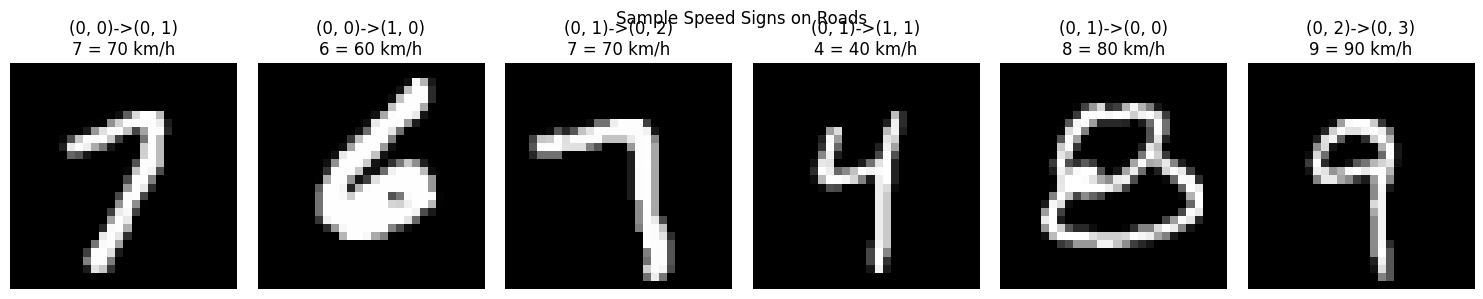

neural agent init: (0, 0) -> (4, 4)
starting neural agent at (0, 0)
neural: exploring (0, 1)
camera: (0, 0)->(0, 1) recognized=70 km/h (conf=1.000) actual=70 km/h
neural: exploring (1, 1)
camera: (0, 1)->(1, 1) recognized=40 km/h (conf=1.000) actual=40 km/h
neural: exploring (1, 0)
camera: (1, 1)->(1, 0) recognized=20 km/h (conf=1.000) actual=20 km/h
neural: exploring (2, 0)
camera: (1, 0)->(2, 0) recognized=70 km/h (conf=1.000) actual=70 km/h
neural: exploring (3, 0)
camera: (2, 0)->(3, 0) recognized=90 km/h (conf=1.000) actual=90 km/h
neural: exploring (4, 0)
camera: (3, 0)->(4, 0) recognized=50 km/h (conf=0.999) actual=50 km/h
neural: exploring (4, 1)
camera: (4, 0)->(4, 1) recognized=30 km/h (conf=0.993) actual=30 km/h
neural: exploring (3, 1)
camera: (4, 1)->(3, 1) recognized=90 km/h (conf=1.000) actual=90 km/h
neural: exploring (2, 1)
camera: (3, 1)->(2, 1) recognized=70 km/h (conf=1.000) actual=70 km/h
neural: exploring (2, 2)
camera: (2, 1)->(2, 2) recognized=30 km/h (conf=1.00

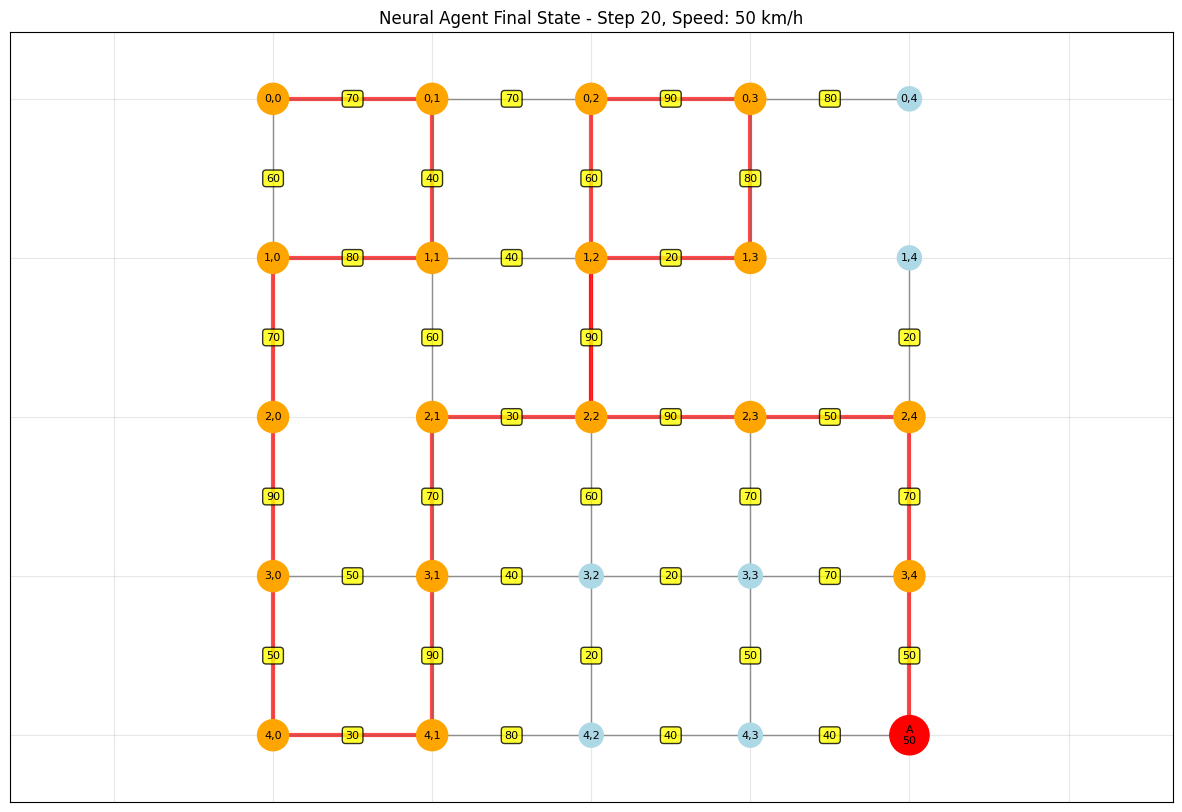

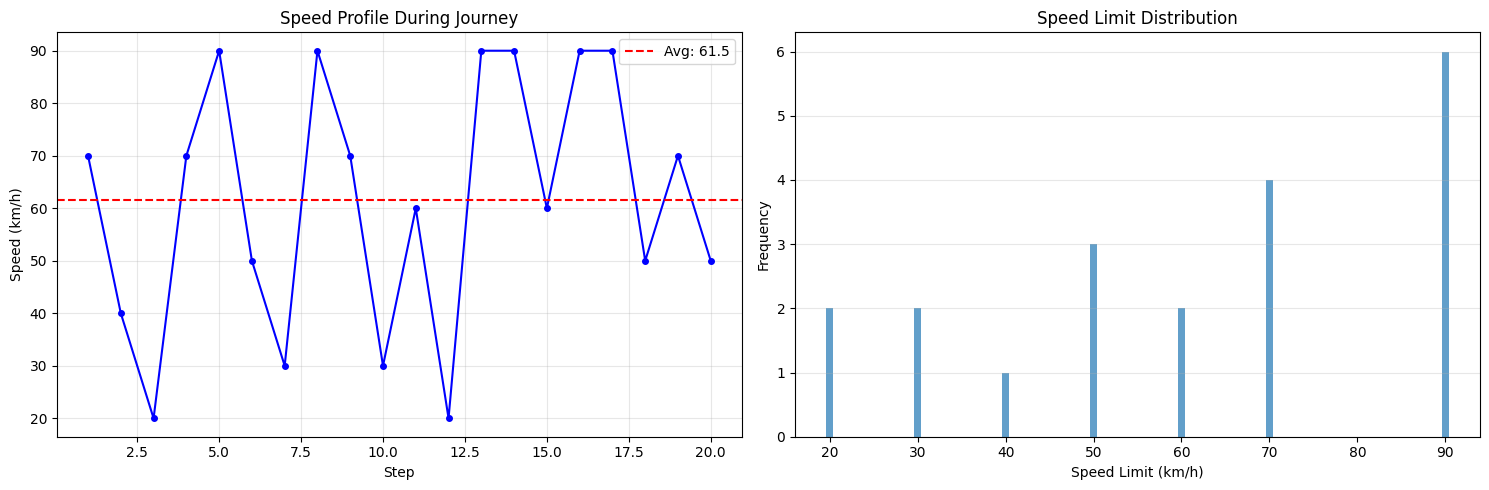

Journey Summary:
Total steps: 20
Total time: 24.53 minutes
Average speed: 61.5 km/h
Speed range: 20-90 km/h


In [10]:
road_graph = RoadGraphWithSpeedSigns(size=5, edges_to_remove=4)
start_pos = (0, 0)
target_pos = (4, 4)

print("Road graph with speed signs created:", road_graph.size, "x", road_graph.size)
print("Removed edges:", len(road_graph.removed_edges))
print("Total road signs:", len(road_graph.road_signs))
print("Total speed signs:", len(road_graph.speed_signs))

show_speed_sign_samples(road_graph)

neural_agent = NeuralNetworkAgent(road_graph, start_pos, target_pos, speed_cnn)
success = neural_agent.run_neural_agent_algorithm(max_steps=50)

visualize_neural_agent_with_speeds(road_graph, neural_agent, "Neural Agent Final State")
plot_journey_analytics(neural_agent)

## Порівняння точності розпізнавання

In [11]:
def test_recognition_accuracy(road_graph: RoadGraphWithSpeedSigns, speed_cnn: SpeedSignCNN, num_tests=20):
    edges = list(road_graph.speed_signs.keys())
    test_edges = random.sample(edges, min(num_tests, len(edges)))
    
    correct_predictions = 0
    total_predictions = 0
    
    print("Testing CNN accuracy on road speed signs:")
    
    for edge in test_edges:
        actual_data = road_graph.get_speed_sign(edge[0], edge[1])
        image = road_graph.get_speed_sign_image(edge[0], edge[1])
        
        if image is not None and actual_data is not None:
            recognition_result = speed_cnn.predict_speed_limit(image)
            
            if recognition_result:
                predicted_speed = recognition_result['speed_limit']
                actual_speed = actual_data['speed_limit']
                confidence = recognition_result['confidence']
                
                is_correct = predicted_speed == actual_speed
                if is_correct:
                    correct_predictions += 1
                    
                total_predictions += 1
                
                status = "✓" if is_correct else "✗"
                print(f"{status} {edge[0]}->{edge[1]}: predicted={predicted_speed}, actual={actual_speed}, conf={confidence:.3f}")
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nAccuracy: {correct_predictions}/{total_predictions} = {accuracy:.3f}")
    
    return accuracy

accuracy = test_recognition_accuracy(road_graph, speed_cnn, num_tests=15)

Testing CNN accuracy on road speed signs:
✓ (3, 3)->(3, 4): predicted=70, actual=70, conf=1.000
✓ (3, 2)->(3, 1): predicted=80, actual=80, conf=1.000
✓ (1, 3)->(0, 3): predicted=90, actual=90, conf=0.996
✓ (0, 2)->(1, 2): predicted=60, actual=60, conf=1.000
✓ (1, 4)->(2, 4): predicted=20, actual=20, conf=1.000
✓ (2, 2)->(1, 2): predicted=60, actual=60, conf=1.000
✓ (2, 2)->(2, 3): predicted=90, actual=90, conf=1.000
✓ (0, 3)->(0, 4): predicted=80, actual=80, conf=1.000
✓ (4, 1)->(3, 1): predicted=90, actual=90, conf=1.000
✓ (1, 1)->(1, 2): predicted=40, actual=40, conf=1.000
✓ (4, 4)->(3, 4): predicted=80, actual=80, conf=1.000
✓ (0, 1)->(1, 1): predicted=40, actual=40, conf=1.000
✓ (3, 4)->(3, 3): predicted=80, actual=80, conf=1.000
✓ (1, 2)->(2, 2): predicted=90, actual=90, conf=1.000
✓ (0, 2)->(0, 3): predicted=90, actual=90, conf=1.000

Accuracy: 15/15 = 1.000


## Демонстрація впливу різних швидкостей

In [12]:
def compare_journey_times(num_tests=3):
    print("Comparing journey times on different road networks:")
    
    for i in range(num_tests):
        road_graph = RoadGraphWithSpeedSigns(size=4, edges_to_remove=random.randint(2, 5))
        start = (0, 0)
        target = (3, 3)
        
        agent = NeuralNetworkAgent(road_graph, start, target, speed_cnn)
        success = agent.run_neural_agent_algorithm(max_steps=30)
        
        if success:
            summary = agent.get_journey_summary()
            print(f"Test {i+1}: {summary['total_steps']} steps, {summary['total_time']:.2f} min, avg speed {summary['avg_speed']:.1f} km/h")
        else:
            print(f"Test {i+1}: Failed to reach target")

compare_journey_times()

Comparing journey times on different road networks:
generated 42 speed signs
neural agent init: (0, 0) -> (3, 3)
starting neural agent at (0, 0)
neural: no action available
neural failed
neural timeout after 30 steps
Test 1: Failed to reach target
generated 40 speed signs
neural agent init: (0, 0) -> (3, 3)
starting neural agent at (0, 0)
neural: exploring (1, 0)
camera: (0, 0)->(1, 0) recognized=20 km/h (conf=1.000) actual=20 km/h
neural: exploring (2, 0)
camera: (1, 0)->(2, 0) recognized=80 km/h (conf=1.000) actual=80 km/h
neural: exploring (3, 0)
camera: (2, 0)->(3, 0) recognized=80 km/h (conf=1.000) actual=80 km/h
neural: exploring (3, 1)
camera: (3, 0)->(3, 1) recognized=40 km/h (conf=1.000) actual=40 km/h
neural: exploring (2, 1)
camera: (3, 1)->(2, 1) recognized=20 km/h (conf=1.000) actual=20 km/h
neural: exploring (2, 2)
camera: (2, 1)->(2, 2) recognized=70 km/h (conf=1.000) actual=70 km/h
neural: exploring (1, 2)
camera: (2, 2)->(1, 2) recognized=80 km/h (conf=1.000) actual=80

## Збереження моделі

In [13]:
speed_cnn.save_model('/Users/admin/WebstormProjects/4th-year/ai-labs/lab4/speed_sign_model.h5')
print("Neural network model saved successfully")

model saved to /Users/admin/WebstormProjects/4th-year/ai-labs/lab4/speed_sign_model.h5
Neural network model saved successfully


## Висновки

У лабораторній роботі №4 було успішно реалізовано:

### 1. Згорткова нейронна мережа
- CNN архітектура для розпізнавання цифр 2-9 з MNIST
- Точність навчання на тестовому наборі
- Інтеграція з системою агента

### 2. Система контролю швидкості
- Генерація випадкових знаків швидкості на дорогах
- Маппінг цифр на обмеження швидкості (20-90 км/год)
- "Камера" агента для сприйняття знаків

### 3. Розширений агент
- Інтеграція з Knowledge-Based архітектурою з Лаб3
- Розпізнавання знаків швидкості через нейромережу
- Контроль швидкості та розрахунок часу подорожі

### 4. Аналітика та візуалізація
- Відстеження профілю швидкості під час руху
- Статистика розподілу швидкостей
- Візуалізація з позначенням швидкостей на дорогах

Агент демонструює успішну інтеграцію комп'ютерного зору та навігаційних алгоритмів для реалістичного автономного руху з дотриманням правил дорожнього руху.